# Multi-agent RAG System 🤖🤝🤖

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

🚨 **NOTE**: This tutorial is advanced. You should have a solid understanding of the concepts discussed in the following cookbooks before diving in:
- [Agents Cookbook](agents)
- [Advanced RAG Cookbook](advanced_rag)

In this notebook, we will create a **multi-agent RAG system**, a system where multiple agents work together to retrieve and generate information, combining the strengths of **retrieval-based systems** and **generative models**.

## What is a Multi-agent RAG System? 🤔

A **Multi-agent Retrieval-Augmented Generation (RAG)** system consists of multiple agents that collaborate to perform complex tasks. The retrieval agent retrieves relevant documents or information, while the generative agent synthesizes that information to generate meaningful outputs.

The original idea for this recipe comes from [this post](https://weaviate.io/blog/what-is-agentic-rag). You may find more details about it there.

Below, you can find the architecture that we will build.


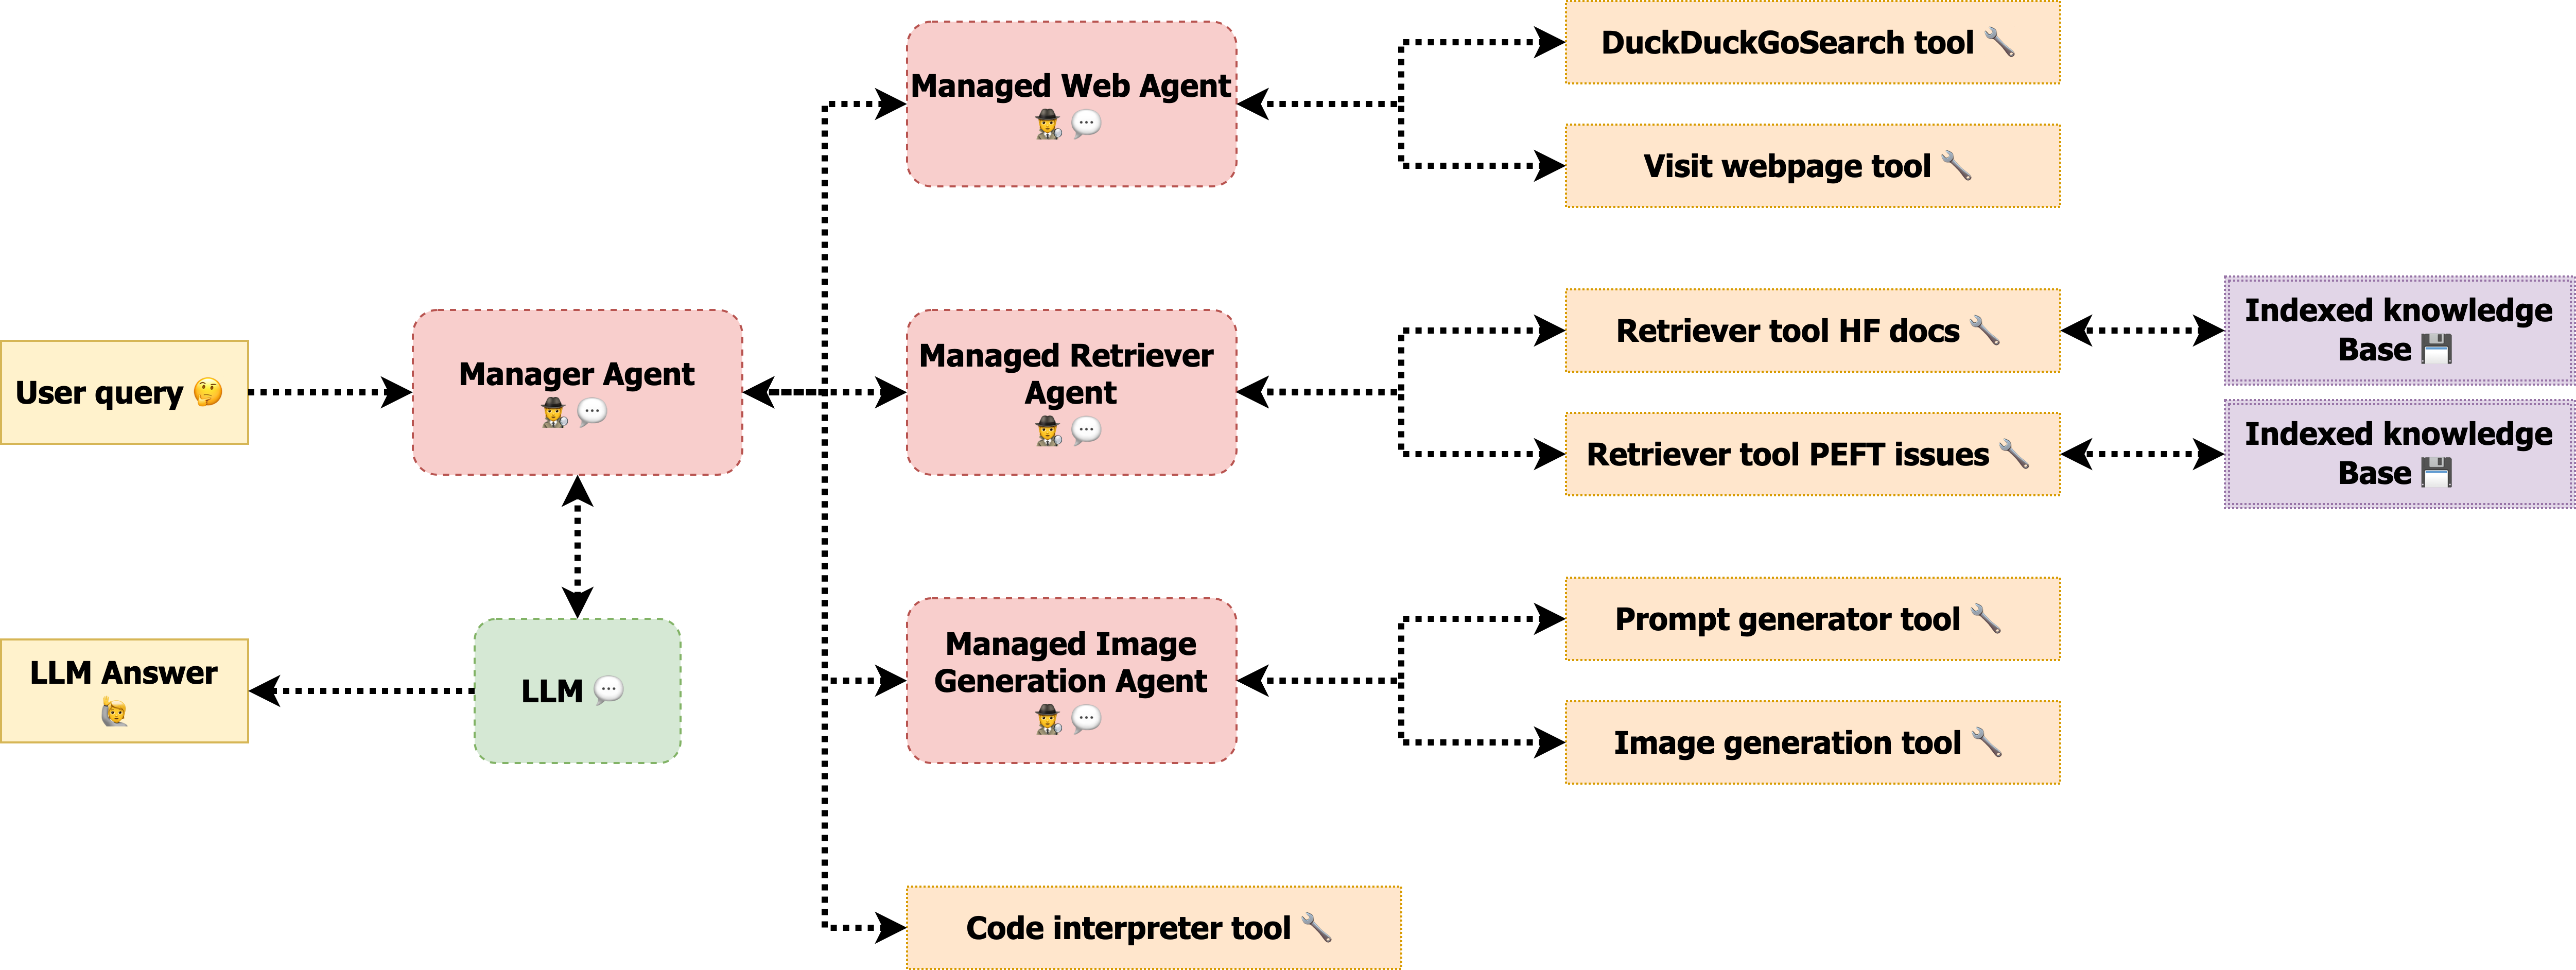

# 1. Install dependencies

First, let's install the dependencies:

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git#egg=transformers[agents]

DEPRECATION: git+https://github.com/huggingface/transformers.git#egg=transformers[agents] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [5]:
!pip install markdownify duckduckgo-search spaces gradio-tools langchain langchain-community langchain-huggingface faiss-cpu --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.8 MB/s eta 0:00:00


Let's login in order to call the HF Inference API:

In [6]:
from huggingface_hub import notebook_login

notebook_login()

# 2. Let's create our multi-agent RAG system

In this section, we will create each of the agents present in our RAG system.

We will have 3 agents managed by a central one (refer to the image for details):

* **🕵💬 Web search agent**: It will include the [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) tool and the visit webpage tool. As you can see, each agent may contain a list of tools.
* **🕵💬 Retriever agent**: It will include two tools for retrieving information from two different sources.
* **🕵💬 Image generation agent**: It will include a prompt generator tool in addition to the image generation tool.

💡 In addition to these agents, the **central agent** will also have access to the **code interpreter tool** to execute code.

We will use [Qwen/Qwen2.5-72B-Instruct](https://huggingface.co/Qwen/Qwen2.5-72B-Instruct) as the LLM for each component, which will be accessed via the Inference API.

> _Note:_ The Inference API hosts models based on various criteria, and deployed models may be updated or replaced without prior notice. Learn more about it [here](https://huggingface.co/docs/api-inference/supported-models).

Let's dive into the details of each agent!



In [7]:
from transformers.agents import HfApiEngine

llm_model = "Qwen/Qwen2.5-72B-Instruct"
llm_engine = HfApiEngine(llm_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 2.1 Web search agent 🔍

The **Web search agent** will utilize the [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) to search the web and gather relevant information. This tool acts as a search engine, querying for results based on the specified keywords.

To make the search results actionable, we also need the agent to access the web pages retrieved by DuckDuckGo. While we could use the built-in `VisitWebpageTool`, we will recreate this tool ourselves to better understand how it works, as shown in the original [Have several agents collaborate in a multi-agent hierarchy 🤖🤝🤖](https://huggingface.co/learn/cookbook/multiagent_web_assistant) recipe.

Let’s explore how to set it up and integrate it into our system!

The following code comes from the original [Have several agents collaborate in a multi-agent hierarchy 🤖🤝🤖](https://huggingface.co/learn/cookbook/multiagent_web_assistant) recipe, so refer to it for more details.





In [5]:
'''
import re
import requests
from markdownify import markdownify as md
from requests.exceptions import RequestException
from transformers.agents import tool


@tool
def visit_webpage(url: str) -> str:
    """Visits a webpage at the given URL and returns its content as a markdown string.

    Args:
        url: The URL of the webpage to visit.

    Returns:
        The content of the webpage converted to Markdown, or an error message if the request fails.
    """
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Convert the HTML content to Markdown
        markdown_content = md(response.text).strip()

        # Remove multiple line breaks
        markdown_content = re.sub(r"\n{3,}", "\n\n", markdown_content)

        return markdown_content

    except RequestException as e:
        return f"Error fetching the webpage: {str(e)}"
    except Exception as e:
        return f"An unexpected error occurred: {str(e)}"
'''

### 2.1.1 Build our multi-tool web agent 🤖

Now that we've set up the basic search and webpage tools, let's build our **multi-tool web agent**. This agent will combine several tools to perform more complex tasks. For this, we will use the `ReactJsonAgent` to handle both web search and webpage extraction tasks.

The agent will be designed to search the web for relevant information and then retrieve detailed content from specific web pages. By integrating multiple tools, we can ensure that the agent is capable of interacting with the web in a more sophisticated manner.

Let's dive into how to set this up and integrate it into our system!


In [8]:
from transformers.agents import ReactCodeAgent, ReactJsonAgent, ManagedAgent
from transformers.agents.search import DuckDuckGoSearchTool, VisitWebpageTool

web_agent = ReactJsonAgent(
    tools=[DuckDuckGoSearchTool(), VisitWebpageTool()],
    llm_engine=llm_engine
)

Now that we have our first agent, let's wrap it as a `ManagedAgent` so the central agent can use it.

In [9]:
managed_web_agent = ManagedAgent(
    agent=web_agent,
    name="search",
    description="Runs web searches for you. Give it your query as an argument.",
)

`managed_agents`  `ReactCodeAgent` `additional_authorized_imports=["time", "datetime"]`

## 2.2 Retriever agent 🤖🔍

The second agent in our multi-agent system is the **Retriever agent**. This agent is responsible for gathering relevant information from different sources. To achieve this, it will utilize two tools that retrieve data from two separate sources.

We will reuse two data sources that were previously used in other RAG recipes, which will allow the retriever to efficiently gather information for further processing.

By leveraging these tools, the Retriever agent can access diverse datasets, ensuring a comprehensive collection of relevant information before passing it on to the next step in the system.

Let's explore how to set up the retriever and integrate it into our multi-agent system!


### 2.2.1 HF docs retriever tool 📚

The first retriever tool comes from the [Agentic RAG: turbocharge your RAG with query reformulation and self-query! 🚀](https://huggingface.co/learn/cookbook/agent_rag) recipe.

For this retriever, we will use a dataset that contains a compilation of documentation pages for various `huggingface` packages, all stored as markdown files. This dataset serves as the knowledge base for the retriever agent to search and retrieve relevant documentation.

To make this dataset easily accessible for our agent, we will:

1. **Download the dataset**: We will first fetch the markdown documentation.
2. **Embed the data**: We will then convert the documentation into embeddings using a **FAISS vector store** for efficient similarity search.

By doing this, the retriever tool can quickly access the relevant pieces of documentation based on the search query, enabling the agent to provide accurate and detailed information.

Let’s go ahead and set up the tool to handle the documentation retrieval!



In [10]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [11]:
from tqdm import tqdm
from transformers import AutoTokenizer
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained("thenlper/gte-small"),
    chunk_size=200,
    chunk_overlap=20,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

# Split docs and keep only unique ones
print("Splitting documents...")
docs_processed = []
unique_texts = {}
for doc in tqdm(source_docs):
    new_docs = text_splitter.split_documents([doc])
    for new_doc in new_docs:
        if new_doc.page_content not in unique_texts:
            unique_texts[new_doc.page_content] = True
            docs_processed.append(new_doc)

print("Embedding documents...")
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
huggingface_doc_vector_db = FAISS.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Splitting documents...


100%|██████████| 2647/2647 [01:34<00:00, 27.90it/s]


Embedding documents...


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now that we have the documentation embedded in FAISS, let's create the **RetrieverTool**. This tool will query the FAISS vector store to retrieve the most relevant documents based on the user’s query.

This will allow the retriever agent to access and provide relevant documentation when queried.



In [12]:
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore

class RetrieverTool(Tool):
    name = "retriever"
    description = "Using semantic similarity, retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.vectordb.similarity_search(
            query,
            k=7,
        )

        return "\nRetrieved documents:\n" + "".join(
            [
                f"===== Document {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [13]:
huggingface_doc_retriever_tool = RetrieverTool(huggingface_doc_vector_db)

### 2.2.2 PEFT issues retriever tool

For the second retriever, we will use the [PEFT issues](https://github.com/huggingface/peft/issues) as data source as in the [Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain](https://huggingface.co/learn/cookbook/rag_zephyr_langchain).

Again, the following code comes from that recipe so refer to it for more details!

In [14]:
from google.colab import userdata
GITHUB_ACCESS_TOKEN = userdata.get('GITHUB_PERSONAL_TOKEN')

In [15]:
from langchain.document_loaders import GitHubIssuesLoader

loader = GitHubIssuesLoader(repo="huggingface/peft", access_token=GITHUB_ACCESS_TOKEN, include_prs=False, state="all")
docs = loader.load()

In [16]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
chunked_docs = splitter.split_documents(docs)

In [17]:
peft_issues_vector_db = FAISS.from_documents(chunked_docs, embedding=embedding_model)

Let's now generate the second retriever tool using the same `RetrieverTool`.

In [18]:
peft_issues_retriever_tool = RetrieverTool(peft_issues_vector_db)

### 2.2.3 Build the Retriever agent

Now that we’ve created the two retriever tools, it’s time to build the **Retriever agent**. This agent will manage both tools and retrieve relevant information based on the user query.

We’ll use the `ManagedAgent` to integrate these tools and pass the agent to the central agent for coordination.


In [19]:
retriever_agent = ReactJsonAgent(
    tools=[huggingface_doc_retriever_tool, peft_issues_retriever_tool], llm_engine=llm_engine, max_iterations=4, verbose=2
)

In [20]:
managed_retriever_agent = ManagedAgent(
    agent=retriever_agent,
    name="retriever",
    description="Retrieves documents from the knowledge base for you that are close to the input query. Give it your query as an argument.",
)

## 2.3 Image generation agent 🎨

The third agent in our system is the **Image generation agent**. This agent will have two tools: one for refining the user query and another for generating the image based on the query.

You can find more details about the image generation agent in the [Agents, supercharged - Multi-agents, External tools, and more](https://huggingface.co/docs/transformers/en/agents_advanced) documentation.

Let’s dive into how these tools will work together to generate images based on user input!




In [21]:
from gradio_tools import StableDiffusionPromptGeneratorTool
from transformers import load_tool, CodeAgent

gradio_prompt_generator_tool = StableDiffusionPromptGeneratorTool()
prompt_generator_tool = Tool.from_gradio(gradio_prompt_generator_tool)

Loaded as API: https://microsoft-promptist.hf.space ✔


In [22]:
image_generation_tool = load_tool("m-ric/text-to-image", cache=False)
image_generation_agent = CodeAgent(tools=[prompt_generator_tool, image_generation_tool], llm_engine=llm_engine)

You're loading a tool from the Hub from None. Please make sure this is a source that you trust as the code within that tool will be executed on your machine. Always verify the code of the tools that you load. We recommend specifying a `revision` to ensure you're loading the code that you have checked.


tool_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tool.py:   0%|          | 0.00/650 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/spaces/m-ric/text-to-image:
- tool.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
TextToImageTool implements a different description in its configuration and class. Using the tool configuration description.


🖼 Again, we use `ManagedAgent` to manage the tell the central agent that it can manage it. Additionally, we’ve included an `additional_prompting` parameter to ensure the agent returns the generated image instead of just a text description.

In [23]:
# MAKE IT RETURN THE IMAGE OBJECT
managed_image_generation_agent = ManagedAgent(
    agent=image_generation_agent,
    name="image_generation",
    description="Generates images from text prompts. Give it your prompt as an argument.",
    additional_prompting="\n\nYour final answer MUST BE only the generated image",
)

# 3. Let's add the general agent manager to orchestrate the system

The **central agent manager** will coordinate tasks between the agents. It will:

- **Receive user input** and decide which agent (Web search, Retriever, Image generation) handles it.
- **Delegate tasks** to the appropriate agent based on the user's query.
- **Collect and synthesize** results from the agents.
- **Return the final output** to the user.

We include all the agents we’ve developed as `managed_agents` and add any necessary imports for the code executor under `additional_authorized_imports`.

In [24]:
# CAN WE MANAGE PRIORITY FOR EACH AGENT?
# SHOULD WE ADD A DIFFERENT TYPE OF AGENT?
manager_agent = ReactCodeAgent(
    tools=[],
    llm_engine=llm_engine,
    managed_agents=[managed_web_agent, managed_retriever_agent, managed_image_generation_agent],
    additional_authorized_imports=["time", "datetime", "PIL"],
)

Now that everything is set up, let's test the performance of the multi-agent RAG system!

To do so, we'll provide some example queries and observe how the system delegates tasks between the agents, processes the information, and returns the final results.

This will help us understand the efficiency and effectiveness of our agents working together, and identify areas for optimization if necessary.

Let's go ahead and run some tests!

## 3.1 First example

In [25]:
manager_agent.run("How many years ago was Stripe founded?")

======== New task ========
How many years ago was Stripe founded?
=== Agent thoughts:
Thought: I need to find out when Stripe was founded, so I can then calculate how many years ago that was. I will use the `search` tool to find the founding year of Stripe.
>>> Agent is executing the code below:
founding_year = search("When was Stripe founded?")
print(founding_year)
====
======== New task ========
You're a helpful agent named 'search'.
You have been submitted this task by your manager.
---
Task:
When was Stripe founded?
---
You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much information as possible so that they have a clear understanding of the answer.

Your final_answer WILL HAVE to contain these parts:
### 1. Task outcome (short version):
### 2. Task outcome (extremely detailed version):
### 3. Additional context (if relevant):

Put all these in your final_answer tool, everything that you do not pass as an argument to final_

14

## 3.2 Second example

In [26]:
result = manager_agent.run(
    "Improve this prompt, then generate an image of it.", prompt='A rabbit wearing a space suit'
)

======== New task ========
Improve this prompt, then generate an image of it.
You have been provided with these initial arguments: {'prompt': 'A rabbit wearing a space suit'}.
=== Agent thoughts:
Thought: The prompt could be made more descriptive and vivid. I will add some details to describe the rabbit, the space suit, and the setting. Once I have a better prompt, I will use the `image_generation` function to generate an image based on the new prompt.
>>> Agent is executing the code below:
new_prompt = "A fluffy white rabbit with big ears wearing a sleek, futuristic space suit, standing on the surface of a distant planet with a blue sky. The space suit has a reflective visor helmet and a small backpack."
print(new_prompt)
====
Print outputs:
A fluffy white rabbit with big ears wearing a sleek, futuristic space suit, standing on the surface of a distant planet with a blue sky. The space suit has a reflective visor helmet and a small backpack.

=== Agent thoughts:
Thought: Now that I ha


Job Status: Status.STARTING eta: None

Job Status: Status.PROCESSING eta: None

Job Status: Status.PROCESSING eta: None

Job Status: Status.PROCESSING eta: None

Job Status: Status.PROCESSING eta: None


Error in execution: 500 Server Error: Internal Server Error for url: https://api-inference.huggingface.co/models/black-forest-labs/FLUX.1-schnell (Request ID: MamlZ5WAAJakkgG6VCVbX). Be sure to provide correct code.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_http.py", line 406, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 500 Server Error: Internal Server Error for url: https://api-inference.huggingface.co/models/black-forest-labs/FLUX.1-schnell

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/agents.py", line 678, in run
    output = self.python_evaluator(
  File "/usr/local/lib/python3.10/dist-packages/transfor


Job Status: Status.STARTING eta: None

Job Status: Status.PROCESSING eta: None

Job Status: Status.PROCESSING eta: None


Print outputs:
The refined prompt is a fluffy white rabbit wearing a sleek, futuristic space suit, standing on the surface of a distant planet with a blue sky, hyperdetailed, artstation, cgsociety, 8 k.

Last output from code snippet:
/tmp/tmp8q9inhr3/7cf73669-8b43-4dd6-ac26-aabc0d91681b.png
=== Agent thoughts:
Thought: The image generation was successful this time. I will return the final answer using the `final_answer` function.
>>> Agent is executing the code below:
final_answer("/tmp/tmp8q9inhr3/7cf73669-8b43-4dd6-ac26-aabc0d91681b.png")
====
Print outputs:

Last output from code snippet:
/tmp/tmp8q9inhr3/7cf73669-8b43-4dd6-ac26-aabc0d91681b.png
Final answer:
/tmp/tmp8q9inhr3/7cf73669-8b43-4dd6-ac26-aabc0d91681b.png


In [27]:
result

'/tmp/tmp8q9inhr3/7cf73669-8b43-4dd6-ac26-aabc0d91681b.png'

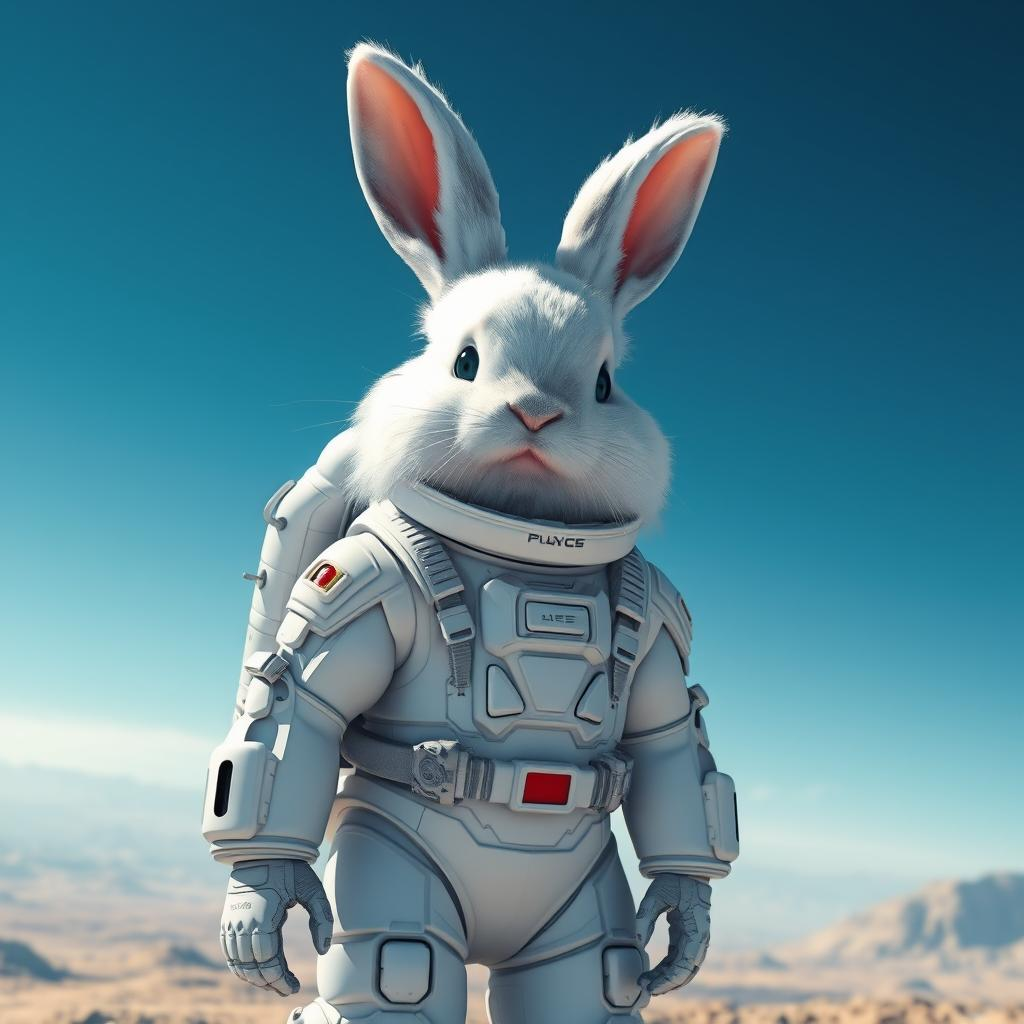

In [28]:
from IPython.display import Image, display

display(Image(filename=result))

## 3.3 Third example

In [31]:
manager_agent.run("How can I push a model to the Hub?")

======== New task ========
How can I push a model to the Hub?
=== Agent thoughts:
Thought: To push a model to the Hugging Face Model Hub, one typically needs to use the `transformers` and `huggingface_hub` libraries. I will first check if these libraries are installed, and if not, install them. Then, I'll provide the steps for pushing a model to the Hub.
>>> Agent is executing the code below:
try:
    import transformers
    import huggingface_hub
except ImportError:
    !pip install transformers huggingface_hub
====
Code execution failed due to the following error:
The code generated by the agent is not valid.
invalid syntax (<unknown>, line 5)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python_interpreter.py", line 886, in evaluate_python_code
    expression = ast.parse(code)
  File "/usr/lib/python3.10/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 5
    !pip install tra

{'steps': ['1. Install the necessary libraries: Run `!pip install transformers` in your terminal or notebook.',
  '2. Import the required modules: Add `from transformers import AutoModel, AutoTokenizer` to your Python script or notebook.',
  "3. Load your model and tokenizer: Use `model = AutoModel.from_pretrained('path/to/your/model')` and `tokenizer = AutoTokenizer.from_pretrained('path/to/your/model')`. Replace `path/to/your/model` with the actual path to your model.",
  '4. Log in to the Hugging Face Hub: Use `from huggingface_hub import notebook_login` and `notebook_login()` to log in.',
  "5. Push the model and tokenizer to the Hub: Use `model.push_to_hub('username/model-name')` and `tokenizer.push_to_hub('username/model-name')`. Replace `username/model-name` with your Hugging Face username and the desired model name.",
  '6. Verify the model is pushed: Go to https://huggingface.co/username/model-name to verify that the model has been pushed.'],
 'commands': ['!pip install transf

## 3.4 Fourth example

In [34]:
manager_agent.run("How do you combine multiple adapters in peft?")

======== New task ========
How do you combine multiple adapters in peft?
=== Agent thoughts:
Thought: To answer this question, I need to understand what "adapters" and "peft" (Parameter-Efficient Fine-Tuning) are, and how they can be combined. I will start by searching for information on PEFT and adapters.
>>> Agent is executing the code below:
info_peft = search('What is PEFT (Parameter-Efficient Fine-Tuning)?')
print("PEFT Info:", info_peft)

info_adapters = search('What are adapters in deep learning?')
print("Adapters Info:", info_adapters)
====
Code execution failed due to the following error:
EXECUTION FAILED:
Evaluation stopped at line 'info_peft = search('What is PEFT (Parameter-Efficient Fine-Tuning)?')' because of the following error:
It is not permitted to evaluate other functions than the provided tools or functions defined in previous code (tried to execute search).
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/agents/python

KeyboardInterrupt: 

🏁 **Final Thoughts**

We have successfully built a multi-agent RAG system that integrates Web Search, Document Retrieval, and Image Generation agents, all orchestrated by a central agent manager. This architecture enables seamless task delegation, efficient processing, and the flexibility to handle a wide variety of user queries.

🔍 **Explore More**

- [Agents Cookbook](agents)
- [Advanced RAG Cookbook](advanced_rag)
- [Learn more about Agentic RAG](https://weaviate.io/blog/what-is-agentic-rag)
